In [1]:
import pandas as pd
import numpy as np
from os import path

import matplotlib.pyplot as plt

from scipy.signal import lfilter

from scipy.linalg import eigh, block_diag
from numpy.linalg import inv, det, pinv
from numpy import kron, log, eye, diag, zeros, ones, empty

idx = pd.IndexSlice

from pandas.tseries.offsets import MonthBegin

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Define functions

## InitCond

### InitCond

In [3]:
def InitCond(X, r, p, spec, blocks, optNaN, Rcon, q):
    
    nQ = sum(spec.Frequency.eq('q'));   # Number of quarterly series
    Qv = spec.loc[spec.Frequency.eq('q')].index.tolist()
    Mv = spec.loc[spec.Frequency.eq('m')].index.tolist()

    pC = Rcon.shape[1]    # 5, 'tent' structure size (quarterly to monthly)
    ppC = max(p, pC)

    # OPTS = pd.Series({'disp':0}) # turns off diagnostic information for eigenvalue computation
    xBal, indNaN = remNaNs_spline(X, optNaN)

    T, N = xBal.shape

    xNaN = xBal.copy()
    xNaN[indNaN] = np.nan   # set missing values equal to NaN

    res = xBal.copy()
    resNaN = xNaN.copy()

    # Initialize model coefficient output
    # C = np.empty((25, 0), int)
    C = pd.DataFrame()
    A = pd.DataFrame()
    Q = pd.DataFrame()
    V_0 = pd.DataFrame()

    # Set the first observations as NaNs: For quarterly-monthly aggreg. scheme
    indNaN.iloc[:pC-1, :] = True

    for r_i, b in zip(r, blocks.columns):    # loop for each block

        # Observation eq.
        C_i = pd.DataFrame(np.zeros((N, r_i*ppC)), index=spec.index)
        # lags = [0, 1, ..., ppC], factors = [1, 2, ..., r_i]
        C_i.columns = pd.MultiIndex.from_product([range(ppC), range(1, r_i+1)]) 
        idx_iM = blocks.loc[spec.Frequency.eq('m') & blocks[b].eq(1)].index
        idx_iQ = blocks.loc[spec.Frequency.eq('q') & blocks[b].eq(1)].index

        # Return eigenvectors v with largest r_i eigenvalues d
        d, v = eigh(res.loc[:, idx_iM].cov(), subset_by_index=[idx_iM.shape[0]-r_i, idx_iM.shape[0]-1])
        v = pd.DataFrame(v, index=idx_iM, columns=list(range(1, r_i+1)))

        # Flip sign for cleaner output. Gives equivalent results without this section
        v *= ((sum(v.squeeze()) > 0) * 2 - 1)

        # For monthly series with loaded blocks (rows), replace with eigenvector
        # This gives the loading
        C_i.loc[idx_iM, 0] = pd.concat([v], axis=1, keys=[0])
        f = res.loc[:, idx_iM].dot(v);  # Data projection for eigenvector direction
        F = pd.DataFrame(index=X.iloc[ppC-1:].index)

        # Lag matrix using loading. This is later used for quarterly series
        for kk in range(max(p+1, pC)):
            f_lag = pd.concat([f.shift(kk)], axis=1, keys=[kk])
            F = pd.concat([F, f_lag], axis=1, join='inner')

        Rcon_i = np.kron(Rcon, np.eye(r_i))  # Quarterly-monthly aggregate scheme
        q_i = np.kron(q, np.zeros(r_i))      # Rcon_i * C_i = q_i

        # Produces projected data with lag structure (so pC-1 fewer entries)
        ff = F.iloc[:, :r_i*pC]
        

        for j in idx_iQ: # Loop for quarterly variables
            # For series j, values are dropped to accommodate lag structure
            xx_j = resNaN[j].iloc[pC-1:].copy()

            if (~xx_j.isnull()).sum().squeeze() < ff.shape[1] + 2:
                xx_j = res[j].iloc[pC-1:]              # Replaces xx_j with spline if too many NaNs

            ff_j = ff.loc[~xx_j.isnull(), :]

            xx_j = xx_j.loc[~xx_j.isnull()]
            iff_j = inv(ff_j.T.dot(ff_j))

            Cc = iff_j.dot(ff_j.T).dot(xx_j)    # least squares

            # Spline data monthly to quarterly conversion
            Cc = Cc - iff_j.dot(Rcon_i.T).dot(inv(Rcon_i.dot(iff_j).dot(Rcon_i.T))).dot(Rcon_i.dot(Cc))
            # Cc = Cc - iff_j.dot(Rcon_i.T).dot(inv(Rcon_i.dot(iff_j).dot(Rcon_i.T))).dot((Rcon_i.dot(Cc)-q_i))

            C_i.loc[j].iloc[:pC*r_i] = Cc

            
        # Zeros in first pC-1 entries (replace dropped from lag)
        ff = pd.concat([pd.DataFrame(0, index=res.iloc[:pC-1].index, columns=ff.columns), ff], axis=0)

        # Residual calculations
        res = res.values - ff.dot(C_i.T)
        resNaN = res.copy()
        resNaN[indNaN] = np.nan

        C = pd.concat([C, pd.concat([C_i], axis=1, keys=[b])], axis=1)

        F.columns = pd.MultiIndex.from_tuples(F.columns)
        F.columns.names = ['p', 'f']

        ## Transition equation
        z = F.loc[:, 0]    # Projected data (no lag)
        Z = F.loc[:, 1:p]  # Data with lag 1

        # Initialize transition matrix
        # f_t = A * f_(t-1)
        A_i = pd.DataFrame(0, index=F.columns, columns=[(i+1,j) for i,j in F.columns])
        A_i.columns = pd.MultiIndex.from_tuples(A_i.columns)
        A_temp = inv(Z.T.dot(Z)).dot(Z.T).dot(z)   # OLS coefficient of AR(p)

        A_i.loc[idx[0, :], idx[:p, :]] = A_temp.T
        A_i.loc[idx[1:, :], idx[:(ppC-1), :]] = np.eye(r_i*(ppC-1))

        Q_i = pd.DataFrame(0, index=F.columns, columns=F.columns)
        e = z.squeeze() - Z.dot(A_temp).squeeze()                  # VAR residuals
        Q_i.loc[0, 0] = np.cov(e, rowvar=False)                    # VAR covariance matrix

        initV_i = inv(eye((r_i*ppC)**2)-kron(A_i,A_i)).dot(Q_i.values.flatten('F')).reshape(r_i*ppC,r_i*ppC,order='F')
        initV_i = pd.DataFrame(initV_i, index=Q_i.index, columns=Q_i.columns)

        # Gives top left block for the transition matrix
        A = bdkg_index(A, A_i, b)
        Q = bdkg_index(Q, Q_i, b)
        V_0 = bdkg_index(V_0, initV_i, b)
        

    for df in [A, Q, V_0]:
        df.index = pd.MultiIndex.from_tuples(df.index)
        df.columns = pd.MultiIndex.from_tuples(df.columns)


    # C = [C Cm Cy]
    Cm = pd.DataFrame(np.eye(N), index=spec.index, columns=spec.index).loc[:, Mv]
    Cm.columns = pd.MultiIndex.from_product([Cm.columns, [0], [1]])
    C = pd.concat([C, Cm], axis=1)

    Cy = pd.DataFrame(0, index=spec.index, columns=pd.MultiIndex.from_product([Qv, range(pC), [1]]))
    for j in Qv:
        Cy.loc[j, j] = [1, 2, 3, 2, 1]

    # Monthly-quarterly aggregate scheme
    C = pd.concat([C, Cy], axis=1)
    R = pd.DataFrame(np.diag(np.var(resNaN)), index=resNaN.columns, columns=resNaN.columns)

    BM = pd.DataFrame(0, index=Mv, columns=Mv);        # Initialize monthly transition matrix values
    SM = pd.DataFrame(0, index=Mv, columns=Mv);        # Initialize monthly residual covariance matrix values

    for v in Mv:
        # Set observation equation residual covariance matrix diagonal
        R.loc[v, v] = 1e-04;

        # Subsetting series residuals for series i
        res_i = resNaN.loc[:, v].copy();

        # Returns number of leading/ending zeros
        rem_i = res_i.isnull()
        leadZero = rem_i.cumsum() == list(range(1, rem_i.shape[0]+1))
        endZero = (rem_i.sum() - rem_i.cumsum() + rem_i) == list(range(rem_i.shape[0], 0, -1))

        # Truncate leading and ending zeros
        res_i = res.loc[:, [v]].copy();
        res_i = res_i.loc[~leadZero & ~endZero]

        # Linear regression: AR 1 process for monthly series residuals
        BM.loc[[v], [v]] = inv(res_i.iloc[:-1].T.dot(res_i.iloc[:-1])).dot(res_i.iloc[:-1].T).dot(res_i.iloc[1:])
        SM.loc[[v], [v]] = (res_i-res_i.shift(1).dot(BM.loc[[v],[v]])).cov();  # Residual covariance matrix

    sig_e = pd.DataFrame(0, index=Qv, columns=['sig']) 

    for v in Qv:
        sig_e.loc[v] = R.loc[v, v] / 19.0
        R.loc[v, v] = 1e-04                 # Covariance for obs matrix residuals

    # For BQ, SQ
    rho0 = 0.1;
    temp = np.zeros((5,5));
    temp[0,0] = 1;

    # Blocks for covariance matrices
    SQ = kron(np.diag((1-rho0**2)*sig_e.squeeze()), temp)
    BQ = kron(np.eye(nQ), np.append([[rho0, 0, 0, 0, 0]], 
                                    np.append(np.eye(4), np.zeros((4,1)), axis=1), axis=0))
    initViQ = inv(np.eye((ppC*nQ)**2)-kron(BQ,BQ)).dot(SQ.flatten('F')).reshape(ppC*nQ,ppC*nQ)
    initViM = np.diag(1/np.diag(np.eye(BM.shape[0])-BM**2))*SM

    BQ = pd.DataFrame(BQ, index=pd.MultiIndex.from_product([Qv, range(pC)]), 
                      columns=pd.MultiIndex.from_product([Qv, range(1, pC+1)]))

    SQ = pd.DataFrame(SQ, index=pd.MultiIndex.from_product([Qv, range(pC)]), 
                      columns=pd.MultiIndex.from_product([Qv, range(pC)]))

    initViQ = pd.DataFrame(initViQ, index=pd.MultiIndex.from_product([Qv, range(pC)]), 
                           columns=pd.MultiIndex.from_product([Qv, range(pC)]))

    # Output
    BM.index = BM.columns = Cm.columns
    BQ.index = BQ.columns = Cy.columns
    SM.index = SM.columns = Cm.columns
    SQ.index = SQ.columns = Cy.columns
    initViM.index = initViM.columns = Cm.columns
    initViQ.index = initViQ.columns = Cy.columns
    
    A = bkdg_flat_index(bkdg_flat_index(A, BM), BQ)                # Observation matrix
    Q = bkdg_flat_index(bkdg_flat_index(Q, SM), SQ)                # Residual covariance matrix (transition)
    Z_0 = pd.Series(np.zeros(A.shape[0]), index=A.index)           # States
    V_0 = bkdg_flat_index(bkdg_flat_index(V_0, initViM), initViQ)  # Covariance of states
    
    A.index = A.columns = pd.MultiIndex.from_tuples(A.index)
    Q.index = Q.columns = pd.MultiIndex.from_tuples(Q.index)
    V_0.index = V_0.columns = pd.MultiIndex.from_tuples(Q.index)
    Z_0.index = pd.MultiIndex.from_tuples(Q.index)

    return A, C, Q, R, Z_0, V_0

### load_spec, load_data, nanLE, bdkg_index, bdkg_flat_index

In [121]:
def load_spec(filename):
    spec = pd.read_excel(filename, sheet_name='spec');

    # keep variables with Model == 1 and drop 'Model' column
    spec = spec.loc[spec.Model.eq(1)].drop('Model', axis=1)

    spec_sort = pd.DataFrame()
    for f in ['d', 'w', 'm', 'q', 'sa', 'a']:
        spec_sort = pd.concat([spec_sort, spec.loc[spec.Frequency.eq(f)]], axis = 0)

    UnitsTransformed_dict = {'lin':'Levels (No Transformation)', 'chg':'Change (Difference)',
                             'ch1':'Year over Year Change (Difference)', 'pch':'Percent Change',
                             'pc1':'Year over Year Percent Change', 'pca':'Percent Change (Annual Rate)',
                             'cch':'Continuously Compounded Rate of Change', 
                             'cca':'Continuously Compounded Annual Rate of Change', 'log':'Natural Log'}

    spec_sort['UnitsTransformed'] = spec_sort['Transformation']
    spec_sort['UnitsTransformed'] = spec_sort['UnitsTransformed'].replace(UnitsTransformed_dict)
    spec_sort = spec_sort.set_index('SeriesID')
    Blocks = spec_sort.filter(regex='^Block', axis=1)
    Blocks.columns = [i for j,i in Blocks.columns.str.split('-').tolist()]
    
    spec_sort = spec_sort[spec_sort.columns.drop(list(spec_sort.filter(regex='Block')))]

    return spec_sort, Blocks


def load_data(datafile, spec, sample_start):
    Z = pd.read_excel(datafile, sheet_name='data')
    Z = Z.set_index('Date')
    Z = Z.asfreq('MS')

    if Z.dropna(how='all', axis=0).shape[0] != Z.shape[0]:
        print('Data file has missing dates.')

    Z.index.names = ['Time']    
    Z = Z.loc[:, spec.index]

    T, N = Z.shape

    f2m = dict(zip(['m', 'q', 'sa', 'a'], [1, 3, 6, 12])) # 
    f2a = dict(zip(['m', 'q', 'sa', 'a'], [12, 4, 2, 1])) # 

    X = pd.DataFrame(np.nan, index=Z.index, columns=Z.columns)

    for var in Z.columns:
        formular = spec.loc[var, 'Transformation']
        freq = spec.loc[var, 'Frequency']
        if formular == 'lin':   # Levels (No Transformation)
            X.loc[:, var] = Z.loc[:, var]
        elif formular == 'chg': # Change (Difference)
            X.loc[:, var] = Z.loc[:, var].diff(f2m[freq])
        elif formular == 'ch1': # YoY Change (Difference)
            X.loc[:, var] = Z.loc[:, var].diff(12)
        elif formular == 'pch': # Percent Change
            X.loc[:, var] = Z.loc[:, var].pct_change(f2m[freq], fill_method=None) * 100
        elif formular == 'pc1': # YoY Percent Change
            X.loc[:, var] = Z.loc[:, var].pct_change(12, fill_method=None) * 100
        elif formular == 'pca': # Percent Change (annualised)
            X.loc[:, var] = ((Z.loc[:, var].pct_change(f2m[freq], fill_method=None) + 1)**f2a[freq] - 1) * 100
        elif formular == 'log': # Natural log
            X.loc[:, var] = np.log(Z.loc[:, var])
        else:
            print('Transformation formular not found.')        

    Z = Z.loc[sample_start:]
    X = X.loc[sample_start:]    
    
    ## DATA Normalization and InitCond
    Mx = X.mean(skipna=True)
    Wx = X.std(skipna=True)
    Xn = (X - Mx)/Wx        # Standardize series

    return Xn, Mx, Wx, X, Z


def nanLE(rem1, X):
    nanLead = rem1.cumsum() == list(range(1, rem1.shape[0] + 1))  # 위부터 연속하여 NaN인 행 식별
    nanEnd = ((rem1.sum() - rem1.cumsum() + rem1)                 # rem1.cumsum(reverse=True)
               == list(range(rem1.shape[0], 0, -1)))              # 아래부터 연속하여 NaN인 행 식별
    nanLE = nanLead | nanEnd                                      # 위 또는 아래부터 연속하여 NaN인 행 식별
    X = X.loc[~nanLE]
    indNaN = X.isnull()
    return X, indNaN


def bdkg_index(A, A_i, b):
    index = [(bb, ii, jj) for bb, ii, jj in A.index] + [(b, ii, jj) for ii, jj in A_i.index]
    columns = [(bb, ii, jj) for bb, ii, jj in A.columns] + [(b, ii, jj) for ii, jj in A_i.columns]
    A = pd.DataFrame(block_diag(A, A_i), index=index, columns=columns)
    return A


def bkdg_flat_index(A, B):
    index = A.index.to_flat_index().tolist() + B.index.to_flat_index().tolist()
    columns = A.columns.to_flat_index().tolist() + B.columns.to_flat_index().tolist()
    A = pd.DataFrame(block_diag(A, B), index=index, columns=columns)
    return A

### remNans_spline, filtering, 

In [5]:
def filtering(X, k):
    Y = X.copy()
    for var in X.columns:
        x = X[var].copy()
        isnanx = x.isnull()
        t1 = isnanx[isnanx.eq(False)].index[0]
        t2 = isnanx[isnanx.eq(False)].index[-1]
        x[t1:t2] = x[t1:t2].interpolate('cubic')  # GDPC1 with method 2: 1.4759/1.4731, 1.4277/1.4151 (matlab/python)
        isnanx = x.isnull()
        x.loc[x.isnull()] = x.median(skipna=True)
        x_ext = np.append(np.append([x.values[0]]*k, x.values), [x.values[-1]]*k)
        x_ma = lfilter(np.ones(2*k+1)/(2*k+1), 1, x_ext)  # equivalent to filter() in MATLAB
        x_ma = x_ma[2*k:]
        x_repl = pd.Series(x_ma, index=x.index)
        x[isnanx] = x_repl[isnanx]                # very similar to matlab; 1.7855/1.7851, 1.8790/1.8795 (matlab/python)
        Y.loc[:, var] = x
    return Y

def remNaNs_spline(X, optNaN): # spline without NaNs
    indNaN = X.isnull()
    T, N = X.shape

    if optNaN.method==1:     # replace all the missing values
        for var in X.columns:
            x = X[var].copy()
            isnanx = x.isnull()
            x.loc[isnanx] = x.median(skipna=True)
            x_ext = np.append(np.append([x.values[0]]*optNaN.k, x.values), [x.values[-1]]*optNaN.k)
            x_ma = lfilter(np.ones(2*optNaN.k+1)/(2*optNaN.k+1), 1, x_ext)
            x_ma = x_ma[2*k:]
            x_repl = pd.Series(x_ma, index=x.index)
            x[isnanx] = x_repl[isnanx]
            X[var] = x
        
    elif optNaN.method==2:   # replace missing values after removing leading and closing zeros
        rem1 = indNaN.sum(axis=1) > .8 * N                            # 80% 이상 변수의 값이 NaN인 행 식별(NaN행)
        X, indNaN = nanLE(rem1, X)
        X = filtering(X, optNaN.k)
            
    elif optNaN.method==3: # only remove rows with leading and closing zeros
        rem1 = indNaN.sum(axis=1) == N                                # 모든 변수의 값이 NaN인 행 식별(NaN행)
        X, indNaN = nanLE(rem1, X)
        
    elif optNaN.method==4:  # remove rows with leading and closing zeros & replace missing values
        rem1 = indNaN.sum(axis=1) == N                                # 모든 변수의 값이 NaN인 행 식별(NaN행)
        X, indNaN = nanLE(rem1, X)
        X = filtering(X, optNaN.k)
        
    elif optNaN.method==5:  # replace missing values  
        indNaN = X.isnull()
        X = filtering(X, optNaN.k)
    
    return X, indNaN

## Kalman filter/smoother

### MissData

In [6]:
def MissData(y, C, R):
    # Syntax:
    # Description:
    #   Eliminates the rows in y & matrices C, R that correspond to missing 
    #   data (NaN) in y
    #
    # Input:
    #   y: Vector of observations at time t
    #   C: Observation matrix
    #   R: Covariance for observation matrix residuals
    #
    # Output:
    #   y: Vector of observations at time t (reduced)     
    #   C: Observation matrix (reduced)     
    #   R: Covariance for observation matrix residuals
    #   L: Used to restore standard dimensions(n x #) where # is the nr of 
    #      available data in y

    # Returns 1 for nonmissing series
    ix = ~np.isnan(y)

    # Index for columns with nonmissing variables
    e = np.eye(y.shape[0])
    L = e[:, ix]

    # Removes missing series
    y = y[ix]

    # Removes missing series from observation matrix
    C = C[ix, :]

    # Removes missing series from transition matrix
    R = R[ix, ix]

    return y, C, R, L

### FIS

In [7]:
def FIS(A, Zm, ZmU, Vm, VmU, loglik, k_t):
    # Applies fixed-interval smoother
    #
    #  Description:
    #    SKF() applies a fixed-interval smoother, and is used in conjunction 
    #    with SKF(). See  page 154 of 'Forecasting, structural time series models 
    #    and the Kalman filter' for more details (Harvey, 1990).
    #
    #  Input parameters:
    #    A: m-by-m transition matrix 
    #    S: structure returned by SKF() 
            #    S.Zm: m-by-nobs matrix, prior/predicted factor state vector
            #          (S.Zm(:,t) = Z_t|t-1)
            #    S.ZmU: m-by-(nobs+1) matrix, posterior/updated state vector
            #           (S.Zm(t+1) = Z_t|t)
            #    S.Vm: m-by-m-by-nobs array, prior/predicted covariance of factor
            #          state vector (S.Vm(:,:,t) = V_t|t-1)  
            #    S.VmU: m-by-m-by-(nobs+1) array, posterior/updated covariance of
            #           factor state vector (S.VmU(:,:,t+1) = V_t|t)
            #    S.loglik: scalar, value of likelihood function
            #    S.k_t: k-by-m Kalman gain
    #
    #  Output parameters:
    #    S: FIS() adds the following smoothed estimates to the S structure: 
    #    - S.ZmT: m-by-(nobs+1) matrix, smoothed states
    #             (S.ZmT(:,t+1) = Z_t|T) 
    #    - S.VmT: m-by-m-by-(nobs+1) array, smoothed factor covariance
    #             matrices (S.VmT(:,:,t+1) = V_t|T = Cov(Z_t|T))
    #    - S.VmT_1: m-by-m-by-nobs array, smoothed lag 1 factor covariance
    #               matrices (S.VmT_1(:,:,t) = Cov(Z_t Z_t-1|T))
    #
    #  Model:
    #   Y_t = C_t Z_t + e_t for e_t ~ N(0, R)
    #   Z_t = A Z_{t-1} + mu_t for mu_t ~ N(0, Q)

    ## ORGANIZE INPUT ---------------------------------------------------------
    # Initialize output matrices    
    nobs, m = Zm.shape
    ZmT = np.zeros((nobs+1,m))
    VmT = np.zeros((nobs+1,m,m))

    # Fill the final period of ZmT, VmT with SKF() posterior values
    ZmT[nobs,:] = ZmU[nobs, :].squeeze()
    VmT[nobs,:,:] = VmU[nobs,:,:].squeeze()

    # Initialize VmT_1 lag 1 covariance matrix for final period
    VmT_1 = np.zeros((nobs,m,m))
    VmT_1[nobs-1,:,:] = (np.eye(m)-k_t).dot(A).dot(VmU[nobs-1,:,:].squeeze())

    # Used for recursion process. See companion file for details
    J_2 = VmU[nobs-1,:,:].squeeze().dot(A.T).dot(pinv(Vm[nobs-1,:,:]))

    
    ## RUN SMOOTHING ALGORITHM ----------------------------------------------
    # Loop through time reverse-chronologically (starting at final period nobs)
    for t in range(nobs-1, -1, -1):
        # Store posterior and prior factor covariance values 
        VmUt = VmU[t,:,:].squeeze()
        Vmt = Vm[t,:,:].squeeze()
        
        # Store previous period smoothed factor covariance and lag-1 covariance
        VmT_t_1 = VmT[t+1,:,:].squeeze()
        VmT_1t = VmT_1[t,:,:].squeeze()
        
        J_1 = J_2
        
        # Update smoothed factor estimate
        ZmT[t,:] = ZmU[t,:] + J_1.dot(ZmT[t+1,:] - A.dot(ZmU[t,:]))
        
        # Update smoothed factor covariance matrix
        VmT[t,:,:] = VmUt + J_1.dot(VmT_t_1 - Vmt).dot(J_1.T)
        
        
        if t > 0:
            # Update weight
            J_2 = VmU[t-1,:,:].squeeze().dot(A.T).dot(pinv(Vm[t-1,:,:].squeeze()))
            
            # Update lag 1 factor covariance matrix 
            VmT_1[t-1,:,:] = VmUt.dot(J_2.T) + J_1.dot(VmT_1t - A.dot(VmUt)).dot(J_2.T)
            

    return ZmT, VmT, VmT_1

### SKF

In [40]:
def SKF(Y, A, C, Q, R, Z_0, V_0):
    #  Description:
    #    SKF() applies the Kalman filter
    #
    #  Input parameters:
    #    Y: k-by-nobs matrix of input data
    #    A: m-by-m transition matrix 
    #    C: k-by-m observation matrix
    #    Q: m-by-m covariance matrix for transition equation residuals (mu_t)
    #    R: k-by-k covariance for observation matrix residuals (e_t)
    #    Z_0: 1-by-m vector, initial value of state
    #    V_0: m-by-m matrix, initial value of state covariance matrix
    #
    #  Output parameters:
    #    S.Zm: m-by-nobs matrix, prior/predicted factor state vector
    #          (S.Zm(:,t) = Z_t|t-1)
    #    S.ZmU: m-by-(nobs+1) matrix, posterior/updated state vector
    #           (S.Zm(t+1) = Z_t|t)
    #    S.Vm: m-by-m-by-nobs array, prior/predicted covariance of factor
    #          state vector (S.Vm(:,:,t) = V_t|t-1)  
    #    S.VmU: m-by-m-by-(nobs+1) array, posterior/updated covariance of
    #           factor state vector (S.VmU(:,:,t+1) = V_t|t)
    #    S.loglik: scalar, value of likelihood function
    #    S.k_t: k-by-m Kalman gain

    ## INITIALIZE OUTPUT VALUES ---------------------------------------------   
    # Output structure & dimensions of state space matrix
    k, m = C.shape   # k * m: observable variables and factors

    # Outputs time for data matrix. "number of observations"
    nobs  = Y.shape[1]

    # Instantiate output
    Zm     = np.ones((nobs, m)) * np.nan       # Z_t | t-1 (prior)
    Vm     = np.ones((nobs, m, m)) * np.nan    # V_t | t-1 (prior)
    ZmU    = np.ones((nobs+1, m)) * np.nan;    # Z_t | t (posterior/updated)
    VmU    = np.ones((nobs+1, m, m)) * np.nan; # V_t | t (posterior/updated)
    loglik = 0

    ## SET INITIAL VALUES ----------------------------------------------------
    Zu = Z_0.copy()  # Z_0|0 (In below loop, Zu gives Z_t | t)
    Vu = V_0.copy()  # V_0|0 (In below loop, Vu guvse V_t | t)

    # Store initial values
    ZmU[0, :]     = Zu.copy()
    VmU[0, :, :]  = Vu.copy()

    ## KALMAN FILTER PROCEDURE ----------------------------------------------
    for t in range(nobs):
        
        ### CALCULATING PRIOR DISTIBUTION----------------------------------
        # Use transition eqn to create prior estimate for factor
        # i.e. Z = Z_t|t-1
        Z = A.dot(Zu)

        # Prior covariance matrix of Z (i.e. V = V_t|t-1)
        # Var(Z) = Var(A*Z+u_t) = A*Vu*A' + Q
        V = A.dot(Vu).dot(A.T) + Q
        V = (V+V.T)/2               # Trick to make symmetric

        ### CALCULATING POSTERIOR DISTRIBUTION ----------------------------
        # Removes missing series: These are removed from Y, C, and R
        Y_t, C_t, R_t, L = MissData(Y[:, t], C, R)


        # Check if y_t contains no data. If so, replace Zu and Vu with prior.
        if Y_t.size==0:
            Zu = Z
            Vu = V
        else:
            # Steps for variance and population regression coefficients:
            # Var(c_t*Z_t + e_t) = c_t Var(A) c_t' + Var(u) = c_t*V *c_t' + R
            VC = V.dot(C_t.T)
            iF = inv(C_t.dot(VC) + R_t)

            # Matrix of population regression coefficients (QuantEcon eqn #4)
            VCF = VC.dot(iF)

            # Gives difference between actual and predicted observation
            # matrix values
            innov = Y_t - C_t.dot(Z)

            # Update estimate of factor values (posterior)
            Zu = Z  + VCF.dot(innov)

            # Update covariance matrix (posterior) for time t
            Vu = V  - VCF.dot(VC.T)
            Vu = (Vu+Vu.T)/2 # Approximation trick to make symmetric

            # Update log likelihood 
            loglik = loglik + 0.5*(log(det(iF)) - innov.T.dot(iF).dot(innov))


        ### STORE OUTPUT----------------------------------------------------
        # Store covariance and observation values for t-1 (priors)
        Zm[t, :] = Z
        Vm[t, :, :] = V

        # Store covariance and state values for t (posteriors)
        # i.e. Zu = Z_t|t   & Vu = V_t|t
        ZmU[t+1, :] = Zu
        VmU[t+1, :, :] = Vu


    # Store Kalman gain k_t
    if Y_t.size==0:
        k_t = np.zeros((m,m))
    else:
        k_t = VCF.dot(C_t)

    return Zm, ZmU, Vm, VmU, loglik, k_t

### runKF

In [39]:
def runKF(Y, A, C, Q, R, Z_0, V_0):
    #  Description:
    #    runKF() applies a Kalman filter and fixed-interval smoother. The
    #    script uses the following model:
    #           Y_t = C_t Z_t + e_t for e_t ~ N(0, R)
    #           Z_t = A Z_{t-1} + mu_t for mu_t ~ N(0, Q)

    #  Throughout this file:
    #    'm' denotes the number of elements in the state vector Z_t.
    #    'k' denotes the number of elements (observed variables) in Y_t.
    #    'nobs' denotes the number of time periods for which data are observed.
    #
    #  Input parameters:
    #    Y: k-by-nobs matrix of input data
    #    A: m-by-m transition matrix 
    #    C: k-by-m observation matrix
    #    Q: m-by-m covariance matrix for transition equation residuals (mu_t)
    #    R: k-by-k covariance for observation matrix residuals (e_t)
    #    Z_0: 1-by-m vector, initial value of state
    #    V_0: m-by-m matrix, initial value of state covariance matrix
    #
    #  Output parameters:
    #    zsmooth: k-by-(nobs+1) matrix, smoothed factor estimates
    #             (i.e. zsmooth(:,t+1) = Z_t|T)
    #    Vsmooth: k-by-k-by-(nobs+1) array, smoothed factor covariance matrices
    #             (i.e. Vsmooth(:,:,t+1) = Cov(Z_t|T))
    #    VVsmooth: k-by-k-by-nobs array, lag 1 factor covariance matrices
    #              (i.e. Cov(Z_t,Z_t-1|T))
    #    loglik: scalar, log-likelihood
    #
    #  References:
    #  - QuantEcon's "A First Look at the Kalman Filter"
    #  - Adapted from replication files for:
    #    "Nowcasting", 2010, (by Marta Banbura, Domenico Giannone and Lucrezia 
    #    Reichlin), in Michael P. Clements and David F. Hendry, editors, Oxford 
    #    Handbook on Economic Forecasting.
    #
    # The software can be freely used in applications. 
    # Users are kindly requested to add acknowledgements to published work and 
    # to cite the above reference in any resulting publications
    
    states = pd.MultiIndex.from_tuples(A.index)
    periods0 = Y.columns
    periods1 = pd.date_range(Y.columns[0], Y.columns[-1] + MonthBegin(), freq=Y.columns.freq)
    
    periods0_states = pd.MultiIndex.from_tuples([(i, j, p, q) 
                                                for i in periods0 for j, p, q in states.to_flat_index()])
    periods1_states = pd.MultiIndex.from_tuples([(i, j, p, q) 
                                                  for i in periods1 for j, p, q in states.to_flat_index()])
    
    Y, A, C, Q, R = Y.to_numpy(), A.to_numpy(), C.to_numpy(), Q.to_numpy(), R.to_numpy()
    Z_0, V_0 = Z_0.to_numpy(), V_0.to_numpy()

    Zm, ZmU, Vm, VmU, loglik, k_t = SKF(Y, A, C, Q, R, Z_0, V_0)   # Kalman filter
    ZmT, VmT, VmT_1 = FIS(A, Zm, ZmU, Vm, VmU, loglik, k_t)        # Fixed interval smoother

    # Organize output 
    Zsmooth = pd.DataFrame(ZmT, index=periods1, columns=states)
    
    VmT = VmT.reshape(VmT.shape[0]*VmT.shape[1], VmT.shape[2])
    VmT_1 = VmT_1.reshape(VmT_1.shape[0]*VmT_1.shape[1], VmT_1.shape[2])
    
    Vsmooth = pd.DataFrame(VmT, index=periods1_states, columns=states)
    VVsmooth = pd.DataFrame(VmT_1, index=periods0_states, columns=states)

    return Zsmooth.T, Vsmooth, VVsmooth, loglik, periods0, periods1

## EM

### EMstep

In [50]:
def EMstep(y, A, C, Q, R, Z_0, V_0, r, p, Rcon, q, blocks, spec):
    #  Applies EM algorithm for parameter reestimation
    #
    #  Syntax:
    #  C_new, R_new, A_new, Q_new, Z_0, V_0, loglik
    #    = EMstep(y, A, C, Q, R, Z_0, V_0, r, p, Rcon, q, blocks, spec)
    #
    #  Description:
    #    EMstep reestimates parameters based on the Estimation Maximization (EM)
    #    algorithm. This is a two-step procedure:
    #    (1) E-step: the expectation of the log-likelihood is calculated using
    #        previous parameter estimates.
    #    (2) M-step: Parameters are re-estimated through the maximisation of
    #        the log-likelihood (maximize result from (1)).
    #
    #    See "Maximum likelihood estimation of factor models on data sets with
    #    arbitrary pattern of missing data" for details about parameter
    #    derivation (Banbura & Modugno, 2010). This procedure is in much the
    #    same spirit.
    #
    #  Input:
    #    y:      Series data
    #    A:      Transition matrix
    #    C:      Observation matrix
    #    Q:      Covariance for transition equation residuals
    #    R:      Covariance for observation matrix residuals
    #    Z_0:    Initial values of factors
    #    V_0:    Initial value of factor covariance matrix
    #    r:      Number of common factors for each block (e.g. vector [1 1 1 1])
    #    p:      Number of lags in transition equation
    #    R_mat:  Estimation structure for quarterly variables (i.e. "tent")
    #    q:      Constraints on loadings
    #    nQ:     Number of quarterly series
    #    i_idio: Indices for monthly variables
    #    blocks: Block structure for each series (i.e. for a series, the structure
    #            [1 0 0 1] indicates loadings on the first and fourth factors)
    #
    #  Output:
    #    C_new: Updated observation matrix
    #    R_new: Updated covariance matrix for residuals of observation matrix
    #    A_new: Updated transition matrix
    #    Q_new: Updated covariance matrix for residuals for transition matrix
    #    Z_0:   Initial value of state
    #    V_0:   Initial value of covariance matrix
    #    loglik: Log likelihood
    #
    # References:
    #   "Maximum likelihood estimation of factor models on data sets with
    #   arbitrary pattern of missing data" by Banbura & Modugno (2010).
    #   Abbreviated as BM2010

    ## Initialize preliminary values
    # Store series/model values
    Qv = spec.loc[spec.Frequency.eq('q')].index.tolist()
    Mv = spec.loc[spec.Frequency.eq('m')].index.tolist()

    n, T = y.shape
    nQ = len(Qv)
    nM = n - nQ                  # Number of monthly series
    pC = Rcon.shape[1]
    ppC = max(p,pC)
    num_blocks = blocks.shape[1] # Number of blocks

    # Set missing data series values to 0
    y0 = y.copy()
    nanY = y0.isnull()
    y0[nanY] = 0

    # Initialize output
    C_new = C.copy()
    A_new = A.copy()
    Q_new = Q.copy()
    V_0_new = V_0.copy()
    
    
    ## ESTIMATION STEP: Compute the (expected) sufficient statistics for a single
    # Kalman filter sequence

    # Running the Kalman filter and smoother with current parameters
    # Note that log-liklihood is NOT re-estimated after the runKF step: This
    # effectively gives the previous iteration's log-likelihood
    # For more information on output, see runKF
    Zsmooth, Vsmooth, VVsmooth, loglik, p0, p1 = runKF(y, A, C, Q, R, Z_0, V_0)   # df으로 return할 경우 시간이 오래 걸림

    ## MAXIMIZATION STEP (TRANSITION EQUATION)
    # See (Banbura & Modugno, 2010) for details.

    ### 2A. UPDATE FACTOR PARAMETERS INDIVIDUALLY ----------------------------
    for b in blocks.columns:   # Loop for each block: factors are uncorrelated

        # ESTIMATE FACTOR PORTION OF Q, A
        # Note: EZZ, EZZ_BB, EZZ_FB are parts of equations 6 and 8 in BM 2010

        # E[f_t*f_t' | Omega_T]
        EZZ = (Zsmooth.loc[b, p1[1:]].dot(Zsmooth.loc[b, p1[1:]].T) 
               + Vsmooth.loc[idx[p1[1:], b], b].groupby(level=[1, 2, 3], axis=0).sum().loc[b])

        # E[f_{t-1}*f_{t-1}' | Omega_T]
        EZZ_BB = (Zsmooth.loc[b, p1[:-1]].dot(Zsmooth.loc[b, p1[:-1]].T)
                  + Vsmooth.loc[idx[p1[:-1], b], b].groupby(level=[1, 2, 3], axis=0).sum().loc[b])

        # E[f_t*f_{t-1}' | Omega_T]
        EZZ_FB = (Zsmooth.loc[b, p1[1:]].dot(Zsmooth.shift(axis=1).loc[b, p1[1:]].T)
                  + VVsmooth.loc[idx[:, b], b].groupby(level=[1, 2, 3], axis=0).sum().loc[b])

        # Select transition matrix/covariance matrix for block i
        A_i = A.loc[b, b]
        Q_i = Q.loc[b, b]

        # Equation 6: Estimate VAR(p) for factor
        A_i.loc[0, :p-1] = EZZ_FB.loc[0, :p-1].dot(inv(EZZ_BB.loc[idx[:p-1], idx[:p-1]])).values

        # Equation 8: Covariance matrix of residuals of VAR
        Q_i.loc[0, 0] = (EZZ.loc[0, 0] - A_i.loc[0, idx[:p-1]].dot(EZZ_FB.loc[0, idx[:p-1]].T)).values / T

        # Place updated results in output matrix
        A_new.loc[idx[b, :, :], idx[b, :, :]] = A_i.values
        Q_new.loc[idx[b, :, :], idx[b, :, :]] = Q_i.values
        V_0_new.loc[idx[b, :, :], idx[b, :, :]] = Vsmooth.loc[idx[p1[0], b], b].values

    ### 2B. UPDATING PARAMETERS FOR IDIOSYNCRATIC COMPONENT ------------------

    # Below 3 estimate the idiosyncratic component (for eqns 6, 8 BM 2010)
    # E[f_t*f_t' | \Omega_T]
    EZZ = (diag(diag(Zsmooth.loc[spec.index, p1[1:]].dot(Zsmooth.loc[spec.index, p1[1:]].T))) 
           + diag(diag(Vsmooth.loc[idx[p1[1:], spec.index], spec.index].groupby(level=[1,2,3],axis=0, sort=False).sum())))

    # E[f_{t-1}*f_{t-1}' | \Omega_T]
    EZZ_BB = (diag(diag(Zsmooth.shift(1,axis=1).loc[spec.index, p1[1:]].dot(Zsmooth.shift(1, axis=1).loc[spec.index, p1[1:]].T))) 
              + diag(diag(Vsmooth.loc[idx[p1[:-1], spec.index], spec.index].groupby(level=[1,2,3],axis=0, sort=False).sum())))

    # E[f_t*f_{t-1}' | \Omega_T]
    EZZ_FB = (diag(diag(Zsmooth.loc[spec.index, p1[1:]].dot(Zsmooth.shift(1, axis=1).loc[spec.index, p1[1:]].T))) 
              + diag(diag(VVsmooth.loc[idx[:, spec.index], spec.index].groupby(level=[1,2,3],axis=0, sort=False).sum())))

    states_MQv = Zsmooth.loc[spec.index, p1[1:]].index
    A_i = pd.DataFrame(EZZ_FB.dot(diag(1 / diag(EZZ_BB))), index=states_MQv, columns=states_MQv) # Equation 6
    Q_i = pd.DataFrame((EZZ - A_i.values.dot(EZZ_FB.T)) / T, index=states_MQv, columns=states_MQv) # Equation 8

    # Place updated results in output matrix
    A_new.loc[idx[Mv, :, :], idx[Mv, :, :]] = A_i.loc[Mv, Mv].values
    Q_new.loc[idx[Mv, :, :], idx[Mv, :, :]] = Q_i.loc[Mv, Mv].values
    V_0_new.loc[idx[Mv, :, :], idx[Mv, :, :]] = diag(diag(Vsmooth.loc[idx[p1[0], Mv], Mv]))

    ## 3 MAXIMIZATION STEP (observation equation)

    ### INITIALIZATION AND SETUP ----------------------------------------------
    Z_0_new = Zsmooth.loc[:, p1[0]] # zeros(size(Zsmooth,1),1); #


    R_con = empty((0, 0), int)
    q_con = empty((0, 1), int)

    for r_i in r:
        R_con = block_diag(R_con, kron(Rcon, eye(r_i)))
        q_con = np.append(q_con, np.zeros((r_i*Rcon.shape[0], 1)), axis=0)

    R_con = pd.DataFrame(R_con, columns = A.loc[blocks.columns, blocks.columns].columns)

    blocks_sum = blocks.copy()
    blocks_sum['bc'] = blocks.dot([1, 2, 3, 4])
    blocks_sum = blocks_sum.set_index('bc', append=True).reorder_levels([1, 0],axis=0).sort_index(axis=0)
    bl = blocks_sum.drop_duplicates().loc[[1, 5, 4, 3]]

    for i, row in bl.eq(1).iterrows():

        bs = blocks_sum.drop_duplicates().columns[row].tolist()
        rs = sum(r[bs])

        idx_iM = [v for v in Mv if v in blocks_sum.loc[i[0]].index.tolist()]  # variables need to be ordered as in Mv!
        n_i = len(idx_iM)  

        # Initialize sums in equation 13 of BGR 2010
        denom = zeros((n_i*rs,n_i*rs))    
        nom = zeros((n_i,rs))   

        ### UPDATE MONTHLY VARIABLES: Loop through each period ----------------
        Wd = ~nanY.loc[idx_iM, :].to_numpy()
        Zd = Zsmooth.loc[idx[bs, 0, :], :].to_numpy()
        Vd = Vsmooth.loc[idx[:, bs, 0, :], idx[bs, 0, :]].to_numpy().reshape(T+1, rs, rs)
        yd = y0.loc[idx_iM, :].to_numpy()
        Ze = Zsmooth.loc[idx[idx_iM, 0, :], :].to_numpy()
        Ve = Vsmooth.loc[idx[:, idx_iM, 0, :], idx[bs, 0, :]].to_numpy().reshape(T+1, n_i, rs)

        for t in range(y.shape[1]):
            Wt = diag(Wd[:, t])  # Gives selection matrix (1 for nonmissing values)

            # E[f_t*t_t' | Omega_T]
            denom = (denom + kron(Zd[:, [t+1]].dot(Zd[:, [t+1]].T) + Vd[t+1, :, :], Wt))

            # E[y_t*f_t' | \Omega_T]
            nom = (nom + yd[:, [t]].dot(Zd[:, [t+1]].T) 
                   - Wt[:, :].dot(Ze[:, [t+1]].dot(Zd[:, [t+1]].T) + Ve[t+1, :, :]))

        vec_C = inv(denom).dot(nom.flatten('F'))  # Eqn 13 BGR 2010

        # Place updated monthly results in output matrix
        C_new.loc[idx_iM, idx[bs, 0, :]] = vec_C.reshape(n_i, rs, order='F')


       ### UPDATE QUARTERLY VARIABLES -----------------------------------------
        idx_iQ = [v for v in Qv if v in blocks_sum.loc[i[0]].index.tolist()]  # Index for quarterly series

        # Monthly-quarterly aggregation scheme
        R_con_i = R_con.loc[:, bs].to_numpy()
        q_con_i = q_con.copy()

        # select non-zero rows of R_con_i, q_con_i
        sel_rows = np.any(R_con_i, axis=1)
        R_con_i = R_con_i[sel_rows, :]
        q_con_i = q_con_i[sel_rows, :]

        # Loop through quarterly series in loading. This parallels monthly code
        for j in idx_iQ:

            # Initialization
            denom = zeros((rs*ppC, rs*ppC))
            nom = zeros((1,rs*ppC))

            # Place quarterly values in output matrix
            V_0_new.loc[idx[j, :, :], idx[j, :, :]] = Vsmooth.loc[p0[0]].loc[idx[j, :, :], idx[j, :, :]]
            A_new.loc[idx[j, 0, 1], idx[j, 0, 1]] = A_i.loc[idx[j, 0, 1], idx[j, 0, 1]]
            Q_new.loc[idx[j, 0, 1], idx[j, 0, 1]] = Q_i.loc[idx[j, 0, 1], idx[j, 0, 1]]


            Wd = ~nanY.loc[[j], :].to_numpy()
            Zd = Zsmooth.loc[idx[bs, :, :], :].to_numpy()
            Vd = Vsmooth.loc[idx[:, bs, :, :], idx[bs, :, :]].to_numpy().reshape(T+1, rs*ppC, rs*ppC, order='F')
            yd = y0.loc[[j], :].to_numpy()
            Ze = Zsmooth.loc[idx[j, :, :], :].to_numpy()
            Ve = Vsmooth.loc[idx[:, j, :, :], idx[bs, :, :]].to_numpy().reshape(T+1, ppC, rs*ppC, order='F')

            for t in range(y.shape[1]):
                Wt = diag(Wd[:, t])  # Selection matrix for quarterly values

                # Intermediate steps in BGR equation 13
                denom = (denom + kron(Zd[:, [t+1]].dot(Zd[:, [t+1]].T) + Vd[t+1, :, :], Wt))
                nom = nom + yd[:, [t]].dot(Zd[:, [t+1]].T)
                nom = (nom - Wt.dot(np.array([[1, 2, 3, 2, 1]]).dot(Ze[:, [t+1]]).dot(Zd[:, [t+1]].T) 
                                    + np.array([[1, 2, 3, 2, 1]]).dot(Ve[t+1, :, :])))

            C_i = inv(denom).dot(nom.T)

            # BGR equation 13
            inv_RdR = inv(R_con_i.dot(inv(denom)).dot(R_con_i.T))
            C_i_constr = (C_i - inv(denom).dot(R_con_i.T).dot(inv_RdR).dot(R_con_i.dot(C_i)-q_con_i))

            # Place updated values in output structure
            C_new.loc[[j], idx[bs, :, :]] = C_i_constr.T

    ### 3B. UPDATE COVARIANCE OF RESIDUALS FOR OBSERVATION EQUATION -----------
    # Initialize covariance of residuals of observation equation
    R_new = zeros((n,n))

    Wd = ~nanY.to_numpy()
    Zd = Zsmooth.to_numpy()
    Vd = Vsmooth.to_numpy().reshape(T+1, A.shape[0], A.shape[1])
    yd = y0.loc[:, :].to_numpy()
    Ze = Zsmooth.loc[idx[j, :, :], :].to_numpy()
    Ve = Vsmooth.loc[idx[:, j, :, :], idx[bs, :, :]].to_numpy().reshape(T+1, ppC, rs*ppC)

    for t in range(y.shape[1]):
        Wt = diag(Wd[:, t])            # Selection matrix
        # BGR equation 15
        R_new = (R_new + (yd[:, [t]] - Wt.dot(C_new).dot(Zd[:, [t+1]])).dot((yd[:, [t]] - Wt.dot(C_new).dot(Zd[:, [t+1]])).T)
                 + Wt.dot(C_new).dot(Vd[t+1, :, :]).dot(C_new.T).dot(Wt) + (eye(n)-Wt).dot(R).dot(eye(n) - Wt))

    R_new = R_new / T
    R_new = pd.DataFrame(diag(diag(R_new)), index=R.index, columns=R.columns) #RR(RR<1e-2) = 1e-2;

    for v in Mv:
        R_new.loc[v, v] = 1e-04

    for v in Qv:
        R_new.loc[v, v] = 1e-04

    return C_new, R_new, A_new, Q_new, Z_0_new, V_0_new, loglik

### em_converged

In [51]:
def em_converged(loglik, previous_loglik, threshold=1e-4, check_decreased=1):
    #  checks whether EM algorithm has converged
    #
    #  Syntax:
    #    [converged, decrease] = em_converged(loglik, previous_loglik, threshold, check_increased)
    #
    #  Description:
    #    em_converged() checks whether EM has converged. Convergence occurs if
    #    the slope of the log-likelihood function falls below 'threshold'(i.e.
    #    f(t) - f(t-1)| / avg < threshold) where avg = (|f(t)| + |f(t-1)|)/2
    #    and f(t) is log lik at iteration t. 'threshold' defaults to 1e-4.
    #
    #    This stopping criterion is from Numerical Recipes in C (pg. 423).
    #    With MAP estimation (using priors), the likelihood can decrease
    #    even if the mode of the posterior increases.
    #
    #  Input arguments:
    #    loglik: Log-likelihood from current EM iteration
    #    previous_loglik: Log-likelihood from previous EM iteration
    #    threshold: Convergence threshhold. The default is 1e-4.
    #    check_decreased: Returns text output if log-likelihood decreases.
    #
    #  Output:
    #    converged (numeric): Returns 1 if convergence criteria satisfied, and 0 otherwise.
    #    decrease (numeric): Returns 1 if loglikelihood decreased.

    ## Instantiate variables
    # Threshhold arguments: Checks default behavior
    # if nargin < 3, threshold = 1e-4; end
    # if nargin < 4, check_decreased = 1; end

    # Initialize output
    converged = 0;
    decrease = 0;

    ## Check if log-likelihood decreases (optional)
    if check_decreased:
        if loglik < previous_loglik - 1e-1: # allow for a little imprecision
            print('loglik decreased by {:,.1f} from {:,.1f} to {:,.1f}'.format(previous_loglik-loglik, 
                                                                               previous_loglik, loglik))
            decrease = 1

    ## Check convergence criteria
    delta_loglik = abs(loglik - previous_loglik)               # Difference in loglik
    avg_loglik = (abs(loglik) + abs(previous_loglik) + np.spacing(1))/2

    if (delta_loglik / avg_loglik) < threshold:
        converged = 1                                          # Check convergence
        print('loglik converged with loglik {:.4f}'.format(loglik))

    return converged, decrease, (delta_loglik / avg_loglik)

### DFM

In [157]:
def dfm(y, A, C, Q, R, Z_0, V_0, r, p, Rcon, q, blocks, spec, par):

    pre_loglik = -np.inf
    LL = np.array([-np.inf])
    converged = 0
    gamma = par.gamma
    max_iter = int(par.max_iter)
    threshold = par.threshold
    
    for num_iter in range(max_iter):    # Loop until converges or max iter.

        if converged:
            break

        # Applying EM algorithm
        C_new, R_new, A_new, Q_new, Z_0, V_0, loglik = EMstep(y, A, C, Q, R, Z_0, V_0, r, p, Rcon, q, blocks, spec)

        A = (1-gamma)*A + gamma*A_new
        C = (1-gamma)*C + gamma*C_new
        Q = (1-gamma)*Q + gamma*Q_new
        R = (1-gamma)*R + gamma*R_new

        if num_iter > 2:  # Checking convergence
            converged, decrease, diff_ratio = em_converged(loglik, pre_loglik, threshold, 1)

        if (np.mod(num_iter, 10) == 0) & (num_iter > 0):  # Print updates to command window
            print('Now running the {:}'.format(num_iter), 'th iteration of max {:}'.format(max_iter))
            print('Loglik: {:.4},  {:,.2f} (% Change), diff_ratio: {:,.4}'.format(loglik, 
                                                                                  100*(loglik/pre_loglik-1),
                                                                                  100*diff_ratio))
        LL = np.append(LL, loglik)
        pre_loglik = loglik

    if(num_iter < max_iter):
        print('Successful: Convergence at {:} iterations.'.format(num_iter))
    else:
        print('Stopped because maximum iterations reached')

    # Final run of the Kalman filter
    Zsmooth = runKF(y, A, C, Q, R, Z_0, V_0)[0].T.shift(-1)  # Since Zsmooth's first date is (start_date - 1)
    xsm = Zsmooth.dot(C.T)  # Get smoothed X

    #  Loading the structure with the results --------------------------------
    Xsm = xsm * Wx + Mx # Unstandardized, smoothed
    Z = Zsmooth

    Qv = spec.loc[spec.Frequency.eq('q')].index.tolist()
    Mv = spec.loc[spec.Frequency.eq('m')].index.tolist()
    
    plt.plot(LL)

    return Xsm, Z, A, C, Q, R, Z_0, V_0, LL

# Estimation

## Load `Spec`, `Data`

In [135]:
# User inputs.
vintage = '2016-06-29'; # vintage dataset to use for estimation
country = 'US';         # United States macroeconomic data
sample_start  = '2000-01-01'; # estimation sample
spec, blocks = load_spec('Spec_US_example.xls')
datafile = path.join('data', country, vintage + '.xls')
Xn, Mx, Wx, X, X_data = load_data(datafile, spec, sample_start)

# DFM structure
p = 1;                                   # Number of lags in autoregressive of factor
r = pd.Series(np.ones(blocks.shape[1], dtype=int), 
              index=blocks.columns)  # Number of common factors for each block
# R*Lambda = q; Contraints on the loadings of the quartrly variables
Rcon = np.array([[2, -1,  0,  0,  0],
                 [3,  0, -1,  0,  0],
                 [2,  0,  0, -1,  0],
                 [1,  0,  0,  0, -1]])
q = np.zeros(4)

optNaN = pd.Series({'method':2, 'k':3})
# method=2 : Remove leading and closing zeros
# k=3      : Setting for filter(): See remNaN_spline

A, C, Q, R, Z_0, V_0 = InitCond(Xn, r, p, spec, blocks, optNaN, Rcon, q)

## EM LOOP

$y_t = CZ_t + e \newline
Z_t = AZ_{t-1} + v, \newline
\text{where} y: N \times T, Z: pr \times T$

loglik converged with loglik -1247.3571
Successful: Convergence at 4 iterations.


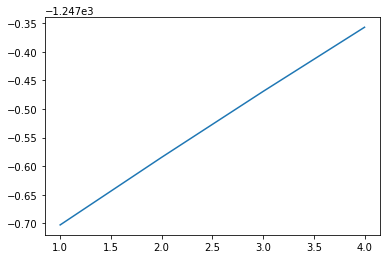

In [140]:
# y for the estimation is WITH missing data
y = Xn.T

# Remove the leading and ending nans
optNaN.method = 3
y_est = remNaNs_spline(Xn, optNaN)[0].T

# parameters for EM loop
par = pd.Series({'threshold':1e-4, 'max_iter':int(5000), 'gamma':0.05})

Xsm, Z, A, C, Q, R, Z_0, V_0, LL = dfm(y_est, A, C, Q, R, Z_0, V_0, r, p, Rcon, q, blocks, spec, par)

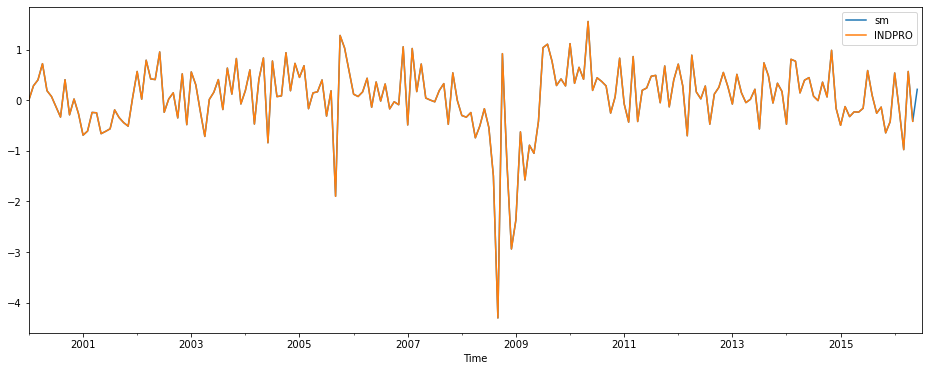

In [156]:
fig, axs = plt.subplots(1, 1, figsize=(16, 6))
Xsm.INDPRO.plot(ax=axs, label='sm')
X.INDPRO.plot(ax=axs)
axs.legend()

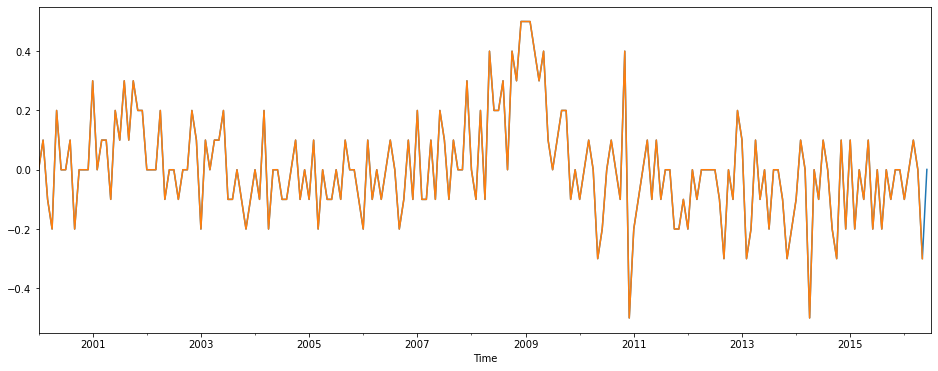

In [151]:
fig, axs = plt.subplots(1, 1, figsize=(16, 6))
Xsm.UNRATE.plot(ax=axs)
X.UNRATE.plot(ax=axs)

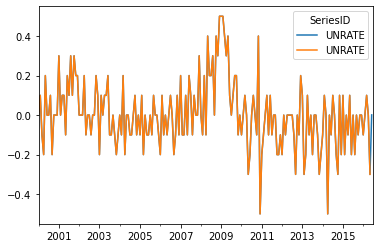

In [154]:
pd.concat([Xsm, X], axis=1).UNRATE.plot()

In [64]:
C.loc[Mv, idx[blocks.columns, 0]]

,Global,Soft,Real,Labor
,0,0,0,0
,1,1,1,1
SeriesID,,,,
PAYEMS,0.252576,0.000000,0.000000,0.589268
JTSJOL,0.094842,0.000000,0.000000,0.425927
CPIAUCSL,0.249419,0.000000,0.000000,0.000000
DGORDER,0.122940,0.000000,0.020750,0.000000
RSAFS,0.217687,0.000000,0.502203,0.000000
UNRATE,-0.187375,0.000000,0.000000,-0.686472
HOUST,0.104531,0.000000,0.284085,0.000000


In [65]:
C.loc[Qv, idx['Global', :]]

Global                                        
                 0         1         2         3         4
                 1         1         1         1         1
SeriesID                                                  
GDPC1     0.034294  0.068588  0.102882  0.068588  0.034294
ULCNFB    0.002850  0.005701  0.008551  0.005701  0.002850

In [57]:
C.loc[Mv, idx[blocks.columns, 0]]

,Global,Soft,Real,Labor
,0,0,0,0
,1,1,1,1
SeriesID,,,,
PAYEMS,0.252576,0.000000,0.000000,0.589268
JTSJOL,0.094842,0.000000,0.000000,0.425927
CPIAUCSL,0.249419,0.000000,0.000000,0.000000
DGORDER,0.122940,0.000000,0.020750,0.000000
RSAFS,0.217687,0.000000,0.502203,0.000000
UNRATE,-0.187375,0.000000,0.000000,-0.686472
HOUST,0.104531,0.000000,0.284085,0.000000


In [58]:
C.loc[Qv, idx['Global', :]]

Global                                        
                 0         1         2         3         4
                 1         1         1         1         1
SeriesID                                                  
GDPC1     0.034294  0.068588  0.102882  0.068588  0.034294
ULCNFB    0.002850  0.005701  0.008551  0.005701  0.002850

In [44]:
Now running the 10 th iteration of max 5000
Loglik: -1.332e+03,  -0.29 (% Change), diff_ratio: 0.2883
Now running the 20 th iteration of max 5000
Loglik: -1.304e+03,  -0.17 (% Change), diff_ratio: 0.1706
Now running the 30 th iteration of max 5000
Loglik: -1.287e+03,  -0.11 (% Change), diff_ratio: 0.1092
Now running the 40 th iteration of max 5000
Loglik: -1.275e+03,  -0.07 (% Change), diff_ratio: 0.0741
Now running the 50 th iteration of max 5000
Loglik: -1.267e+03,  -0.05 (% Change), diff_ratio: 0.05275
Now running the 60 th iteration of max 5000
Loglik: -1.262e+03,  -0.04 (% Change), diff_ratio: 0.03895
Now running the 70 th iteration of max 5000
Loglik: -1.258e+03,  -0.03 (% Change), diff_ratio: 0.02953
Now running the 80 th iteration of max 5000
Loglik: -1.254e+03,  -0.02 (% Change), diff_ratio: 0.0228
Now running the 90 th iteration of max 5000
Loglik: -1.252e+03,  -0.02 (% Change), diff_ratio: 0.01782
Now running the 100 th iteration of max 5000
Loglik: -1.25e+03,  -0.01 (% Change), diff_ratio: 0.014
Now running the 110 th iteration of max 5000
Loglik: -1.248e+03,  -0.01 (% Change), diff_ratio: 0.01099
loglik converged with loglik -1247.8237
Successful: Convergence at 115 iterations.

SyntaxError: invalid syntax (<ipython-input-44-a57b0db7cfcb>, line 1)

In [68]:
C.loc[Mv, idx[blocks.columns, 0]]

,Global,Soft,Real,Labor
,0,0,0,0
,1,1,1,1
SeriesID,,,,
PAYEMS,0.252568,0.000000,0.000000,0.589268
JTSJOL,0.094838,0.000000,0.000000,0.425917
CPIAUCSL,0.249411,0.000000,0.000000,0.000000
DGORDER,0.122933,0.000000,0.020768,0.000000
RSAFS,0.217681,0.000000,0.502222,0.000000
UNRATE,-0.187382,0.000000,0.000000,-0.686472
HOUST,0.104524,0.000000,0.284104,0.000000


In [69]:
C.loc[Qv, idx['Global', :]]

Global                                        
                 0         1         2         3         4
                 1         1         1         1         1
SeriesID                                                  
GDPC1     0.034077  0.068155  0.102232  0.068155  0.034077
ULCNFB    0.002507  0.005013  0.007520  0.005013  0.002507